In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
uploaded = files.upload()

In [40]:
#read Dataset
df_raw = pd.read_csv('vgames2.csv', index_col=0, na_values=['Unknown', 'Misc'])
num_df_before = df_raw.shape[0]

#refine Year
df_raw.loc[df_raw.Year<=22,'Year'] += 2000
df_raw.loc[df_raw.Year<=99,'Year'] += 1900

#refine Sales data
sales_col = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for col in sales_col:
  df_raw[col] = df_raw[col].str.replace('M','')
  df_raw[col] = [(
      ele.replace('K', '') if re.match('.*K', ele) else round(float(ele) * 1000, 3)
      ) for ele in df_raw[col]]

#re-define data type
df_raw = df_raw.sort_values(['Name', 'Platform']).reset_index(drop= True)
(df_raw.isna()).sum()

Name              0
Platform          0
Year            271
Genre          1784
Publisher       261
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
dtype: int64

In [10]:
def update_dupl_na(df_test, df_raw, col):
  def make_dupl(df):
    return df[df.duplicated(subset= 'Name', keep= False) == True].sort_values('Name')
    
  df_not_NA = make_dupl(df_raw).dropna(subset= [col])
  df_NA = make_dupl(df_test).loc[df_test[col].isna() == True,:].copy()

  for i in df_NA.index:
    name = df_NA.loc[i, 'Name']
    df_sub = df_not_NA.query(f'Name == "{name}"')
    if  df_sub.shape[0] > 0:
      df_NA.loc[i, col] = df_sub[col].iloc[0]

  return df_NA

def year_in_title(df):
  df_ret = df[df.Name.str.contains('\d{4}')].\
              loc[df.Year.isna() == True, :].copy()
  for i in df_ret.index:
    name = df.loc[i, 'Name']
    df_ret.loc[i, 'Year'] = int(name[-4:])

  return df_ret

def col_in_title(df_test, df_raw, col):
  df_ret = df_test[df_test[col].isna() == True].copy()
  col_unique = df_raw.dropna(subset = [col])[col].unique()

  for i in df_ret.index:
    name = df_ret.loc[i, 'Name']
    for col_u in col_unique:
      if name.find(col_u) >= 0:
        df_ret.loc[i, col] = col_u
        break
  
  return df_ret

def col_in_series(df_test, df_raw, col):
  df_not_NA = df_raw.dropna(subset= [col])
  df_NA = df_test[df_test[col].isna() == True].copy()

  for name in df_NA.Name.unique():
    name_x = name
    x = name.find(':')
    if x > 0: name_x = name[:x]
    idx = df_NA[df_NA.Name.str.contains(name_x)]
    df_sub = df_not_NA[df_not_NA.Name.str.contains(name_x)]

    if df_sub[col].unique().shape[0] == 1:
      df_NA.loc[idx, col] = df_sub[col].iloc[0]

    return df_NA


def col_in_title_manual(df_test, df_raw, col, sub):
  df_not_NA = df_raw.dropna(subset= [col]).loc[df_raw.Name.str.contains(sub)]
  df_NA = df_test[df_test[col].isna() == True].copy()
  
  if df_not_NA.shape[0] > 0:
    df_NA.loc[df_raw.Name.str.contains(sub), col] = df_not_NA[col].iloc[0]
  
  return df_NA

def clue_year(df_test:pd.DataFrame, df_raw:pd.DataFrame):
  df_not_NA = df_raw.dropna(subset= ['Year'])
  df_NA = df_test[df_test.Year.isna() == True].copy()

  for i in df_NA.index:
    name = df_NA.loc[i, 'Name']
    idx = df_NA.query(f'Name == "{name}"').index
    min = np.min(df_not_NA.Year)
    max = np.max(df_not_NA.Year)
    
    publisher = df_NA.loc[i,'Publisher']
    if publisher in df_raw.Publisher.unique():
      raw_p = df_not_NA.query(f'Publisher == "{publisher}"').Year

      min = np.max([min, np.min(raw_p)])
      max = np.min([max, np.min(raw_p)])

    for j in idx:
      platform = df_NA.Platform.loc[j]
      raw_p = df_not_NA.query(f'Platform == "{platform}"').Year
      
      min = np.max([min, np.min(raw_p)])
      max = np.min([max, np.min(raw_p)])

    df_NA.loc[i, 'Year'] = np.mean([min, max]).round(0)

  return df_NA

In [41]:
#NA control
df = df_raw.copy()

df.update(update_dupl_na(df, df_raw,'Year'))
df.update(update_dupl_na(df, df_raw,'Genre'))
df.update(update_dupl_na(df, df_raw,'Publisher'))

df.update(year_in_title(df))
df.update(col_in_title(df, df_raw, 'Genre'))
df.update(col_in_title(df, df_raw, 'Publisher'))

df.update(col_in_series(df, df_raw, 'Genre'))
df.update(col_in_series(df, df_raw, 'Publisher'))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16458 non-null  float64
 3   Genre        14862 non-null  object 
 4   Publisher    16418 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [42]:
#NA control manually
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Dance ?Dance'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Pokemon .*/Pokemon .*'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Amnesia'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Animal Crossing'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Momotarou Dentetsu'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Myth Makers'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'The Sims'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Minecraft'))

df.update(col_in_title_manual(df, df_raw, 'Genre', 'Mahjong'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Chess|chess'))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16458 non-null  float64
 3   Genre        14925 non-null  object 
 4   Publisher    16418 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [52]:
#replace NAs
df.Genre.fillna('Misc', inplace= True)
df.Publisher.fillna('Unknown', inplace= True)
df.update(clue_year(df, df_raw))

df[['Platform', 'Genre', 'Publisher']] = df[['Platform', 'Genre', 'Publisher']].astype('category')
df[sales_col] = df[sales_col].astype(int)
df = df.convert_dtypes()

#Data Featuring
df['Total_Sales'] = np.sum([df[col] for col in sales_col])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         16598 non-null  string  
 1   Platform     16598 non-null  category
 2   Year         16596 non-null  Int64   
 3   Genre        16598 non-null  category
 4   Publisher    16598 non-null  category
 5   NA_Sales     16598 non-null  Int64   
 6   EU_Sales     16598 non-null  Int64   
 7   JP_Sales     16598 non-null  Int64   
 8   Other_Sales  16598 non-null  Int64   
 9   Total_Sales  16598 non-null  int64   
dtypes: Int64(5), category(3), int64(1), string(1)
memory usage: 1.1 MB


In [53]:
#visualizations
def make_lineplot(df, min=1900, max=2022):
  df_wide = df.\
    loc[(df.Year >= min) & (df.Year <= max),['Year', 'Genre', 'Total_Sales']].\
    groupby(['Year', 'Genre'])['Total_Sales'].sum().reset_index()
  
  return sns.lineplot(data= df_wide, x= 'Year', y= 'Total_Sales', hue= 'Genre')

def make_pie(df, min=1900, max=2022):
  df_gs = df[(df.Year >= min) & (df.Year <= max)].\
    groupby('Genre')[sales_col].sum().sort_values('NA_Sales')

  plt.figure(figsize= [16, 16])
  for i, sale in enumerate(sales_col):
    x = plt.subplot(2, 2, i+1)
    x.ax = plt.pie(data= df_gs, x= sale, labels=df_gs.index)
    plt.title(sale)

  plt.legend();

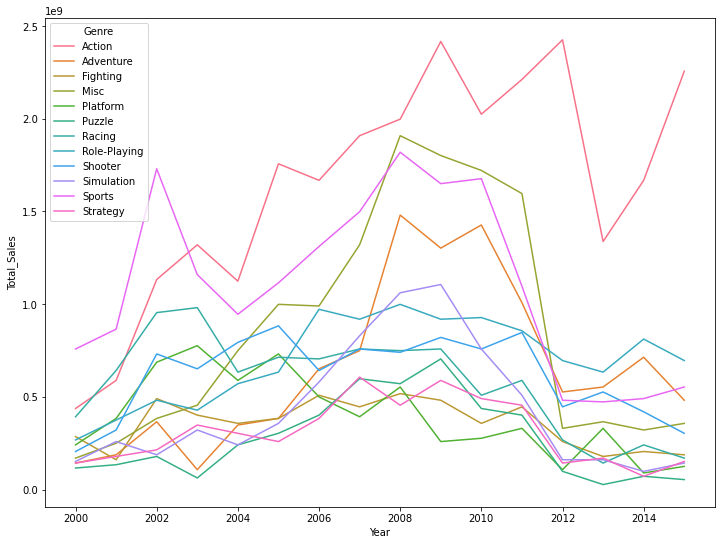

In [54]:
plt.figure(figsize=[12, 9])
make_lineplot(df, min=2000, max=2015)
plt.show();

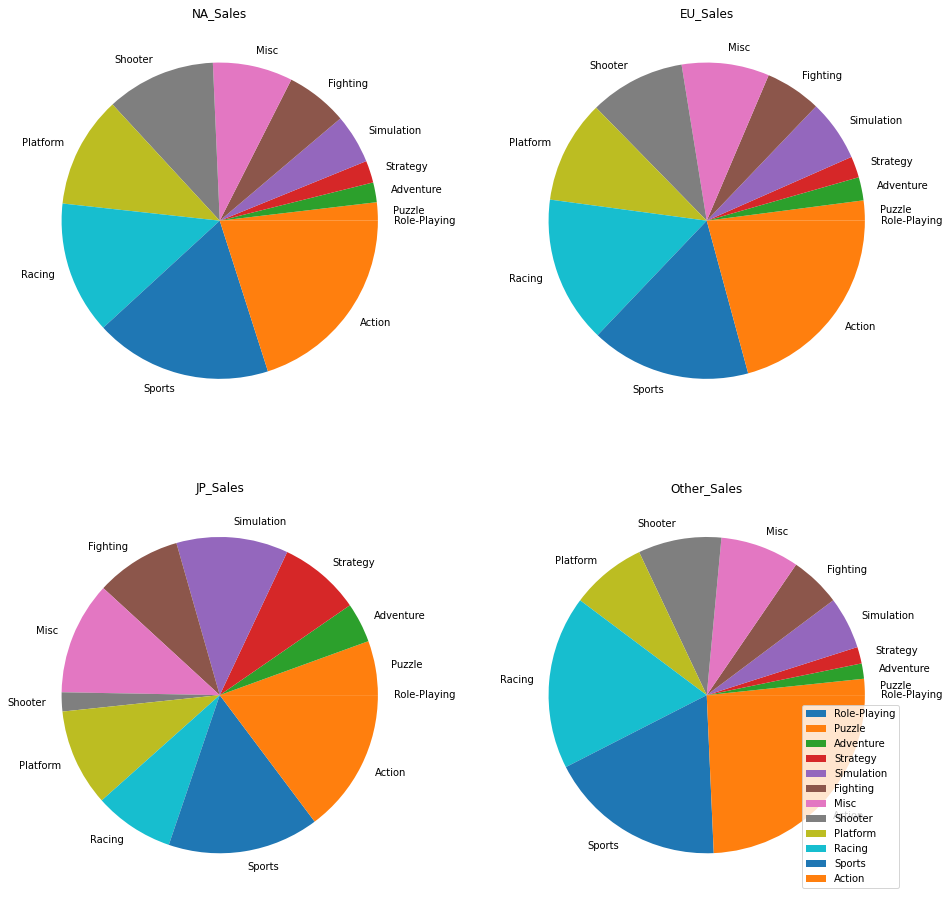

In [55]:
make_pie(df[df.Genre != 'Role-Playing'], min= 1999, max = 2005)